# Preprocessing and featurizing train data

In [ ]:
!pip install jsonlines

In [ ]:
#Loading Json Train Data
import jsonlines
phase=[]
table_id=[]
question=[]
sql=[]
with jsonlines.open("train.jsonl") as f:
  for line in f.iter():
    phase.append(line['phase'])
    table_id.append(line['table_id'])
    question.append(line['question'])
    sql.append(line['sql'])
import pandas as pd
d={'phase':phase,'table_id':table_id,'question':question,'sql':sql}
train_data=pd.DataFrame(d)
train_data
f.close()

In [ ]:
train_data.columns=['phase','id','question','sql']

In [ ]:
import jsonlines
id=[]
header=[]
types=[]
rows=[]
with jsonlines.open("train.tables.jsonl") as f:
  for line in f.iter():
    id.append((line['id']))
    header.append((line['header']))
    types.append((line['types']))
    rows.append(line['rows'])
d={'id':id,'header':header,'types':types,'rows':rows}
train_table_info=pd.DataFrame(d)
train_table_info

,id,header,types,rows
0,1-1000181-1,"[State/territory, Text/background colour, Form...","[text, text, text, text, text, text]","[[Australian Capital Territory, blue/white, Ya..."
1,1-10006830-1,"[Aircraft, Description, Max Gross Weight, Tota...","[text, text, text, text, text]","[[Robinson R-22, Light utility helicopter, 1,3..."
2,1-10007452-3,"[Order Year, Manufacturer, Model, Fleet Series...","[text, text, text, text, text, text]","[[1992-93, Gillig, Phantom (High Floor), 444-4..."
3,1-10015132-1,"[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Quincy Acy, 4, United States, Forward, 2012-..."
4,1-10015132-14,"[Player, No., Nationality, Position, Years in ...","[text, real, text, text, text, text]","[[Patrick O'Bryant, 13, United States, Center,..."
...,...,...,...,...
18580,2-18998832-2,"[Game, Date, Opponent, Venue, Result, Attendance]","[real, text, text, text, text, real]","[[1, 15 August 1987, Swindon Town, Home, 2–0, ..."
18581,2-18998832-5,"[Round (Leg), Date, Opponent, Venue, Result, A...","[text, text, text, text, text, real]","[[2 (1), 22 September 1987, Fulham, Away, 5–1,..."
18582,2-19001175-1,"[Country, Seasons, Championship Titles, Race e...","[text, text, text, text, real, real, real, rea...","[[United Kingdom, 1986, 0, 1, 0, 0, 0, 0, 0], ..."
18583,2-19008019-32,"[!Event, Round, Surface, Winner, Opponent, Res...","[real, text, text, text, text, text]","[[1., Wimbledon, Final, Grass, Roger Federer, ..."


In [ ]:
#merging both tables
merged_data=train_data.merge(train_table_info,on='id')
merged_data

,phase,id,question,sql,header,types,rows
0,1,1-1000181-1,Tell me what the notes are for South Australia,"{'sel': 5, 'conds': [[3, 0, 'SOUTH AUSTRALIA']...","[State/territory, Text/background colour, Form...","[text, text, text, text, text, text]","[[Australian Capital Territory, blue/white, Ya..."
1,1,1-1000181-1,What is the current series where the new serie...,"{'sel': 4, 'conds': [[5, 0, 'New series began ...","[State/territory, Text/background colour, Form...","[text, text, text, text, text, text]","[[Australian Capital Territory, blue/white, Ya..."
2,1,1-1000181-1,What is the format for South Australia?,"{'sel': 2, 'conds': [[0, 0, 'South Australia']...","[State/territory, Text/background colour, Form...","[text, text, text, text, text, text]","[[Australian Capital Territory, blue/white, Ya..."
3,1,1-1000181-1,Name the background colour for the Australian ...,"{'sel': 1, 'conds': [[0, 0, 'Australian Capita...","[State/territory, Text/background colour, Form...","[text, text, text, text, text, text]","[[Australian Capital Territory, blue/white, Ya..."
4,1,1-10007452-3,how many times is the fuel propulsion is cng?,"{'sel': 3, 'conds': [[5, 0, 'CNG']], 'agg': 3}","[Order Year, Manufacturer, Model, Fleet Series...","[text, text, text, text, text, text]","[[1992-93, Gillig, Phantom (High Floor), 444-4..."
...,...,...,...,...,...,...,...
56350,2,2-12200756-16,What time was the match played with a score of...,"{'sel': 1, 'conds': [[5, 0, '3-2']], 'agg': 0}","[Date, Time, Competition, Opponent, Ground, Sc...","[text, text, text, text, text, text]","[[17 July 2007, 15:30 GMT, Friendly Match, Chi..."
56351,2,2-12200756-16,On which ground did the team play Aston Villa?,"{'sel': 4, 'conds': [[3, 0, 'aston villa']], '...","[Date, Time, Competition, Opponent, Ground, Sc...","[text, text, text, text, text, text]","[[17 July 2007, 15:30 GMT, Friendly Match, Chi..."
56352,2,2-12200756-16,What kind of competition was it at San Siro at...,"{'sel': 2, 'conds': [[4, 0, 'san siro'], [1, 0...","[Date, Time, Competition, Opponent, Ground, Sc...","[text, text, text, text, text, text]","[[17 July 2007, 15:30 GMT, Friendly Match, Chi..."
56353,2,2-12214488-1,What is the total number of decile for the red...,"{'sel': 5, 'conds': [[0, 0, 'redwood school']]...","[Name, Years, Gender, Locality, Authority, Dec...","[text, text, text, text, text, real]","[[Amesbury School, 1–6, Coed, Churton Park, St..."


In [ ]:
#Converting dictionary sql answer into sql text for using in seq-seq model
from tqdm import tqdm 
sql_in_text=[]
aggregate=['','MAX','MIN','COUNT','SUM','AVG']
operator=['=','<','>']
word_operator=['eq','lt','gt']

for i in tqdm(range(len(merged_data))):
  sql=merged_data.sql.iloc[i]
  col=merged_data.header.iloc[i][sql['sel']]
  agg=aggregate[sql['agg']]
  cond_col=[]
  cond_opr=[]
  cond_value=[]
  for j in sql['conds']:
    cond_col.append(merged_data.header.iloc[i][j[0]])
    cond_opr.append(word_operator[j[1]])
    cond_value.append(j[2])
  resulted_sql="select "
  if(agg==''):
    resulted_sql+=col+" where "
  else:
    resulted_sql+=agg+"("+col+") where "

  for j in range(len(cond_col)):
    if(j!=0):
      resulted_sql+="and "
    resulted_sql+=cond_col[j]+' '+cond_opr[j]+' '
    resulted_sql+=str(cond_value[j])+' '

  sql_in_text.append(resulted_sql)

100%|██████████| 56355/56355 [00:03<00:00, 14369.95it/s]


In [ ]:
merged_data['resulted_sql']=sql_in_text

In [ ]:
merged_data

,phase,id,question,sql,header,types,rows,resulted_sql
0,1,1-1000181-1,Tell me what the notes are for South Australia,"{'sel': 5, 'conds': [[3, 0, 'SOUTH AUSTRALIA']...","[State/territory, Text/background colour, Form...","[text, text, text, text, text, text]","[[Australian Capital Territory, blue/white, Ya...",select Notes where Current slogan eq SOUTH AUS...
1,1,1-1000181-1,What is the current series where the new serie...,"{'sel': 4, 'conds': [[5, 0, 'New series began ...","[State/territory, Text/background colour, Form...","[text, text, text, text, text, text]","[[Australian Capital Territory, blue/white, Ya...",select Current series where Notes eq New serie...
2,1,1-1000181-1,What is the format for South Australia?,"{'sel': 2, 'conds': [[0, 0, 'South Australia']...","[State/territory, Text/background colour, Form...","[text, text, text, text, text, text]","[[Australian Capital Territory, blue/white, Ya...",select Format where State/territory eq South A...
3,1,1-1000181-1,Name the background colour for the Australian ...,"{'sel': 1, 'conds': [[0, 0, 'Australian Capita...","[State/territory, Text/background colour, Form...","[text, text, text, text, text, text]","[[Australian Capital Territory, blue/white, Ya...",select Text/background colour where State/terr...
4,1,1-10007452-3,how many times is the fuel propulsion is cng?,"{'sel': 3, 'conds': [[5, 0, 'CNG']], 'agg': 3}","[Order Year, Manufacturer, Model, Fleet Series...","[text, text, text, text, text, text]","[[1992-93, Gillig, Phantom (High Floor), 444-4...",select COUNT(Fleet Series (Quantity)) where Fu...
...,...,...,...,...,...,...,...,...
56350,2,2-12200756-16,What time was the match played with a score of...,"{'sel': 1, 'conds': [[5, 0, '3-2']], 'agg': 0}","[Date, Time, Competition, Opponent, Ground, Sc...","[text, text, text, text, text, text]","[[17 July 2007, 15:30 GMT, Friendly Match, Chi...",select Time where Score eq 3-2
56351,2,2-12200756-16,On which ground did the team play Aston Villa?,"{'sel': 4, 'conds': [[3, 0, 'aston villa']], '...","[Date, Time, Competition, Opponent, Ground, Sc...","[text, text, text, text, text, text]","[[17 July 2007, 15:30 GMT, Friendly Match, Chi...",select Ground where Opponent eq aston villa
56352,2,2-12200756-16,What kind of competition was it at San Siro at...,"{'sel': 2, 'conds': [[4, 0, 'san siro'], [1, 0...","[Date, Time, Competition, Opponent, Ground, Sc...","[text, text, text, text, text, text]","[[17 July 2007, 15:30 GMT, Friendly Match, Chi...",select Competition where Ground eq san siro an...
56353,2,2-12214488-1,What is the total number of decile for the red...,"{'sel': 5, 'conds': [[0, 0, 'redwood school']]...","[Name, Years, Gender, Locality, Authority, Dec...","[text, text, text, text, text, real]","[[Amesbury School, 1–6, Coed, Churton Park, St...",select COUNT(Decile) where Name eq redwood sch...


In [ ]:
print("question: ",merged_data.question.iloc[100])
print("headers: ",merged_data.header.iloc[100])
print("sql: ",merged_data.resulted_sql.iloc[100])

question:  What is the season year where the rank is 39?
headers:  ['Season', 'Timeslot ( ET )', 'Season premiere', 'Season finale', 'TV season', 'Rank', 'Viewers (millions)']
sql:  select TV season where Rank eq 39 


**Concatinating headers and questions**

In [ ]:
#Concatinating question and headers
question_header=[]
for i in range(len(merged_data)):
  question=merged_data.question.iloc[i]
  header=merged_data.header.iloc[i]
  #a=header.split(',')
  #for i in range(len(a)):
  #  a[i]=a[i].replace('[','')
  #  a[i]=a[i].replace("'",'')
  #  a[i]=a[i].replace(',','')
  #  a[i]=a[i].replace(']','')
  for head in header: 
    question+=' '+head
  question_header.append(question)

In [ ]:
question_header[0]

'Tell me what the notes are for South Australia  State/territory Text/background colour Format Current slogan Current series Notes'

**Preprocessing**

In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    return text

In [ ]:
import re
preprocess_question_header=[]
for i in question_header:
  preprocess_question_header.append(preprocess(i))

In [ ]:
preprocess_sql_in_text=[]
for i in merged_data['resulted_sql'].values:
  preprocess_sql_in_text.append(preprocess(i))

In [ ]:
preprocess_sql_in_text[100]

'select tv season where rank eq 39 '

In [ ]:
final_data=pd.DataFrame()
final_data['question_header']=question_header
final_data['sql']=preprocess_sql_in_text
final_data

,question_header,sql
0,Tell me what the notes are for South Australia...,select notes where current slogan eq south aus...
1,What is the current series where the new serie...,select current series where notes eq new serie...
2,What is the format for South Australia? State/...,select format where state/territory eq south a...
3,Name the background colour for the Australian ...,select text/background colour where state/terr...
4,how many times is the fuel propulsion is cng? ...,select count(fleet series (quantity)) where fu...
...,...,...
56350,What time was the match played with a score of...,select time where score eq 3-2
56351,On which ground did the team play Aston Villa?...,select ground where opponent eq aston villa
56352,What kind of competition was it at San Siro at...,select competition where ground eq san siro an...
56353,What is the total number of decile for the red...,select count(decile) where name eq redwood sch...


In [ ]:
final_data.question_header.iloc[0]

'Tell me what the notes are for South Australia  State/territory Text/background colour Format Current slogan Current series Notes'

**Featurizing**

In [ ]:
#storing lengths of input and output from final data
input_lengths=final_data['question_header'].str.split().apply(len)
output_lengths=final_data['sql'].str.split().apply(len)

In [ ]:
ci=0
for i in input_lengths:
  if(i>60):
    ci+=1
co=0
for i in output_lengths:
  if(i>35):
    co+=1
print("Number of words in input greater than 60:",ci)
print("Number of words in output greater than 35:",co)

Number of words in input greater than 60: 83
Number of words in output greater than 35: 7


In [ ]:
#only 87 data points are greater than 60 words in input, so we choose max length of 60 in input
pos=[]
for i in range(len(input_lengths)):
  if(input_lengths[i]<=60 and output_lengths[i]<=35):
    pos.append(i)


In [ ]:
data=final_data.iloc[pos]

In [ ]:
data['sql_input'] = '<start> ' + data['sql'].astype(str)
data['sql_output'] = data['sql'].astype(str) + ' <end>'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
data

,question_header,sql,sql_input,sql_output
0,Tell me what the notes are for South Australia...,select notes where current slogan eq south aus...,<start> select notes where current slogan eq s...,select notes where current slogan eq south aus...
1,What is the current series where the new serie...,select current series where notes eq new serie...,<start> select current series where notes eq n...,select current series where notes eq new serie...
2,What is the format for South Australia? State/...,select format where state/territory eq south a...,<start> select format where state/territory eq...,select format where state/territory eq south a...
3,Name the background colour for the Australian ...,select text/background colour where state/terr...,<start> select text/background colour where st...,select text/background colour where state/terr...
4,how many times is the fuel propulsion is cng? ...,select count(fleet series (quantity)) where fu...,<start> select count(fleet series (quantity)) ...,select count(fleet series (quantity)) where fu...
...,...,...,...,...
56350,What time was the match played with a score of...,select time where score eq 3-2,<start> select time where score eq 3-2,select time where score eq 3-2 <end>
56351,On which ground did the team play Aston Villa?...,select ground where opponent eq aston villa,<start> select ground where opponent eq aston ...,select ground where opponent eq aston villa <...
56352,What kind of competition was it at San Siro at...,select competition where ground eq san siro an...,<start> select competition where ground eq san...,select competition where ground eq san siro an...
56353,What is the total number of decile for the red...,select count(decile) where name eq redwood sch...,<start> select count(decile) where name eq red...,select count(decile) where name eq redwood sch...


In [ ]:
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
data.sql_input.iloc[0]= str(data.sql_input.iloc[0])+' <end>'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
data.sql_input.iloc[0]

'<start> select notes where current slogan eq south australia  <end>'

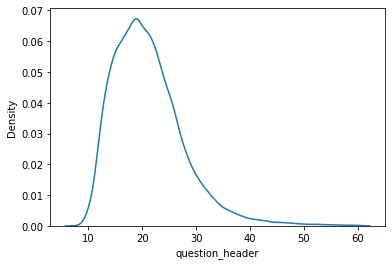

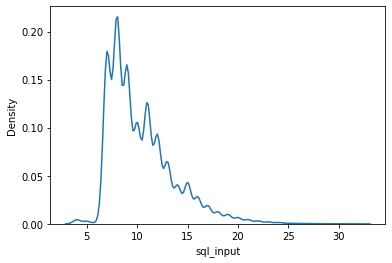

In [ ]:
import matplotlib.pyplot as plt

que_lengths = data['question_header'].str.split().apply(len)
sql_lengths = data['sql_input'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(que_lengths)
plt.show()
sns.kdeplot(sql_lengths)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tknizer_question = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_question.fit_on_texts(data['question_header'].values)
tknizer_sql = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_sql.fit_on_texts(data['sql_input'].values)

In [ ]:
vocab_size_question=len(tknizer_question.word_index.keys())
print(vocab_size_question)
vocab_size_sql=len(tknizer_sql.word_index.keys())
print(vocab_size_sql)

33926
29731


In [ ]:
import pickle
with open('tokenizer_question.pickle', 'wb') as handle:
  pickle. dump(tknizer_question, handle, protocol=pickle. HIGHEST_PROTOCOL)
with open('tokenizer_sql.pickle', 'wb') as handle:
  pickle. dump(tknizer_sql, handle, protocol=pickle. HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open('tokenizer_question.pickle', 'rb') as handle:
  tknizer_question=pickle.load(handle)
with open('tokenizer_sql.pickle', 'rb') as handle:
  tknizer_sql=pickle.load(handle) 

In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2021-11-04 14:25:26--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2021-11-04 14:25:27--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4160af042b5457ab0850db60c6.dl.dropboxusercontent.com/cd/0/inline/BZWjG3wQVsrRMD5Al7UI9mxrAENF24t1bUnjeDZGc8tW9miKlxI3ErDRf_IIu7G-urlZ4Avb5qPJAAsWBHNZcTCCQJ7i_yOKGFvFl3gVlZee8GYGnFFw4ecg_CbEe7ROxY4lqDLMSu8Kivah4Rl-LHNT/file# [following]
--2021-11-04 14:25:27--  https://uc4160af042b5457ab0850db60c6.dl.dropboxusercontent.com/cd/0/inline/BZWjG3wQVsrRMD5Al7UI9mxrAENF24t1bUnjeDZGc8tW9miKlxI3ErDRf_IIu7G-urlZ4Avb5qP

In [ ]:
import numpy as np
from tqdm import tqdm 
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_sql+1,100))  #to convert each unique word in tokenzier's vocab  ==>100-d vector
for word, i in tqdm(tknizer_sql.word_index.items()):
    embedding_vector= embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

400000it [00:13, 29010.05it/s]
100%|██████████| 29731/29731 [00:00<00:00, 434885.65it/s]

(29732, 100)


In [ ]:
embedding_matrix.shape

(29732, 100)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
class Dataset:
    def __init__(self, data, tknizer_question, tknizer_sql, max_len):
        self.encoder_inps = data.question_header.values
        self.decoder_inps = data.sql_input.values
        self.decoder_outs = data.sql_output.values
        self.tknizer_question = tknizer_question
        self.tknizer_sql = tknizer_sql
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_question.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_sql.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_sql.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=36, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=36, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
#max_length=61
train_dataset = Dataset(data, tknizer_question, tknizer_sql, 61)
train_dataloader = Dataloder(train_dataset, batch_size=64)
print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 61) (64, 36) (64, 36)


**Encoder Decoder Model**

In [ ]:
from tensorflow.keras.models import Model

class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self, vocab_size, embedding_dim, enc_units,input_length):
      super().__init__()
      self.vocab_size = vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.enc_units= enc_units
      
    
    def build(self, input_shape):  #emb and lstm layers def
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,mask_zero=True ,name="embedding_layer_encoder")
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM") 
          
    def call(self,input_sequence,init_states,training=True):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedd= self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd,initial_state=init_states)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c
      

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      state_h=tf.zeros((batch_size,self.enc_units))
      state_c=tf.zeros((batch_size,self.enc_units))
      return state_h, state_c
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self, vocab_size, embedding_dim, dec_units,input_length):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = 100
        self.dec_units = dec_units
        self.input_length = input_length
        # we are using embedding_matrix and not training the embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder", trainable=False)
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Encoder_LSTM")
        


    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        target_embedd = self.embedding(input_sequence)
        lstm_output, lstm_h_state,lstm_c_state  = self.lstm(target_embedd, initial_states)
        return lstm_output,lstm_h_state,lstm_c_state 
class Encoder_decoder(Model):
    def __init__(self, encoder_inputs_length,decoder_inputs_length, output_vocab_size,batch_size):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.encoder = Encoder(vocab_size=vocab_size_question+1, embedding_dim=200, enc_units=500,input_length=encoder_inputs_length)
        self.init_states=self.encoder.initialize_states(batch_size=batch_size)
        self.decoder = Decoder(vocab_size=vocab_size_sql+1, embedding_dim=300, dec_units=500,input_length=decoder_inputs_length)
        self.dense   = Dense(output_vocab_size, activation='softmax',name="Dense_Layer")
        
        
    def call(self, data):
        input,output = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(input,self.init_states)
        print(type(input),type(self.init_states)) 
        print("input",input.shape,"init_states",self.init_states.shape) 
        print("encoder_output",encoder_output.shape,"encoder_h", encoder_h.shape,"encoder_c", encoder_c.shape)
        decoder_output,_,_= self.decoder(output,[encoder_h, encoder_c]) 
        output = self.dense(decoder_output) 
        return output    

In [ ]:
'''
Encoder: embedding=50, enc_unit=256
Decoder: embedding=100, dec_unit=256 
epoch=3
Bleu: 0.58

Encoder: embedding=100, enc_unit=364
Decoder: embedding=200, dec_unit=364 
epoch=3
Bleu: 0.594

Encoder: embedding=100, enc_unit=364
Decoder: embedding=200, dec_unit=364 
epoch
Bleu: 0.594
'''

'\nEncoder: embedding=50, enc_unit=256\nDecoder: embedding=100, dec_unit=256 \nepoch=3\nBleu: 0.58\n\nEncoder: embedding=100, enc_unit=364\nDecoder: embedding=200, dec_unit=364 \nepoch=3\nBleu: 0.594\n\nEncoder: embedding=100, enc_unit=364\nDecoder: embedding=200, dec_unit=364 \nepoch\nBleu: 0.594\n'

# Featurizing and fitting along validation data

In [ ]:
#Loading Json Train Data
import jsonlines
phase=[]
table_id=[]
question=[]
sql=[]
with jsonlines.open("dev.jsonl") as f:
  for line in f.iter():
    phase.append(line['phase'])
    table_id.append(line['table_id'])
    question.append(line['question'])
    sql.append(line['sql'])
import pandas as pd
d={'phase':phase,'table_id':table_id,'question':question,'sql':sql}
val_data=pd.DataFrame(d)
val_data
f.close()

In [ ]:
val_data.columns=['phase','id','question','sql']

In [ ]:
import jsonlines
id=[]
header=[]
types=[]
rows=[]
with jsonlines.open("dev.tables.jsonl") as f:
  for line in f.iter():
    id.append((line['id']))
    header.append((line['header']))
    types.append((line['types']))
    rows.append(line['rows'])
d={'id':id,'header':header,'types':types,'rows':rows}
val_table_info=pd.DataFrame(d)
val_table_info

,id,header,types,rows
0,1-10015132-11,"[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Antonio Lang, 21, United States, Guard-Forwa..."
1,1-10015132-9,"[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Jarrett Jack, 1, United States, Guard, 2009-..."
2,1-10026563-1,[Entered office as Head of State or Government...,"[text, text, text, text, text]","[[16 October 1964, 15 November 1975, 5 April 1..."
3,1-1008653-1,"[Country ( exonym ), Capital ( exonym ), Count...","[text, text, text, text, text]","[[Afghanistan, Kabul, Afghanestan افغانستان, K..."
4,1-10088101-1,"[No. in set, No. in series, Title, Directed by...","[real, real, text, text, text, text, text]","[[1, 174, "" Per Manum "", Kim Manners, Chris Ca..."
...,...,...,...,...
2711,2-18999963-3,"[Year, Program, Role, Episode, First aired]","[real, text, text, text, text]","[[1957, Alfred Hitchcock Presents, Charles Cou..."
2712,2-19000748-1,"[Round, Pick, Player, Nationality, College/Jun...","[real, real, text, text, text]","[[1, 3., Rick Hampton, Canada, St. Catharines ..."
2713,2-19000872-1,"[Round, Pick, Player, Nationality, College/jun...","[real, real, text, text, text]","[[1, 5., Mike Crombeen, Canada, Kingston Canad..."
2714,2-19001175-2,"[Country, Total Drivers, Championship Titles, ...","[text, real, text, text, real, real, real, rea...","[[Argentina, 11, 0, 119 (113), 0, 0, 3, 2, 64]..."


In [ ]:
val_merged_data=val_data.merge(val_table_info,on='id')
val_merged_data

,phase,id,question,sql,header,types,rows
0,1,1-10015132-11,What position does the player who played for b...,"{'sel': 3, 'conds': [[5, 0, 'Butler CC (KS)']]...","[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Antonio Lang, 21, United States, Guard-Forwa..."
1,1,1-10015132-11,How many schools did player number 3 play at?,"{'sel': 5, 'conds': [[1, 0, '3']], 'agg': 3}","[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Antonio Lang, 21, United States, Guard-Forwa..."
2,1,1-10015132-11,What school did player number 21 play for?,"{'sel': 5, 'conds': [[1, 0, '21']], 'agg': 0}","[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Antonio Lang, 21, United States, Guard-Forwa..."
3,1,1-10015132-11,Who is the player that wears number 42?,"{'sel': 0, 'conds': [[1, 0, '42']], 'agg': 0}","[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Antonio Lang, 21, United States, Guard-Forwa..."
4,1,1-10015132-11,What player played guard for toronto in 1996-97?,"{'sel': 0, 'conds': [[3, 0, 'Guard'], [4, 0, '...","[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Antonio Lang, 21, United States, Guard-Forwa..."
...,...,...,...,...,...,...,...
8416,2,2-12206617-2,"Which loss has an attendance greater than 49,6...","{'sel': 3, 'conds': [[4, 1, '49,688'], [5, 0, ...","[Date, Opponent, Score, Loss, Attendance, Record]","[text, text, text, text, real, text]","[[April 8, Red Sox, 6 - 2, Stieb (0-1), 50,114..."
8417,2,2-12206617-2,What is the largest attendance that has tigers...,"{'sel': 4, 'conds': [[1, 0, 'tigers'], [3, 0, ...","[Date, Opponent, Score, Loss, Attendance, Record]","[text, text, text, text, real, text]","[[April 8, Red Sox, 6 - 2, Stieb (0-1), 50,114..."
8418,2,2-12601141-1,Which party has Peter A. Quinn as a representa...,"{'sel': 3, 'conds': [[0, 0, 'peter a. quinn']]...","[Representative, Years, State, Party, Lifespan]","[text, text, text, text, text]","[[John A. Quackenbush, 1889–1893, New York, Re..."
8419,2,2-12601141-1,Which state does Jimmy Quillen represent?,"{'sel': 2, 'conds': [[0, 0, 'jimmy quillen']],...","[Representative, Years, State, Party, Lifespan]","[text, text, text, text, text]","[[John A. Quackenbush, 1889–1893, New York, Re..."


In [ ]:
#Converting dictionary sql answer into sql text for using in seq-seq model
from tqdm import tqdm 
sql_in_text=[]
aggregate=['','MAX','MIN','COUNT','SUM','AVG']
operator=['=','<','>']
word_operator=['eq','lt','gt']

for i in tqdm(range(len(val_merged_data))):
  sql=val_merged_data.sql.iloc[i]
  col=val_merged_data.header.iloc[i][sql['sel']]
  agg=aggregate[sql['agg']]
  cond_col=[]
  cond_opr=[]
  cond_value=[]
  for j in sql['conds']:
    cond_col.append(val_merged_data.header.iloc[i][j[0]])
    cond_opr.append(word_operator[j[1]])
    cond_value.append(j[2])
  resulted_sql="select "
  if(agg==''):
    resulted_sql+=col+" where "
  else:
    resulted_sql+=agg+"("+col+") where "

  for j in range(len(cond_col)):
    if(j!=0):
      resulted_sql+="and "
    resulted_sql+=cond_col[j]+' '+cond_opr[j]+' '
    resulted_sql+=str(cond_value[j])+' '

  sql_in_text.append(resulted_sql)

100%|██████████| 8421/8421 [00:00<00:00, 16011.27it/s]


In [ ]:
val_merged_data['resulted_sql']=sql_in_text

In [ ]:
#Concatinating question and headers
question_header=[]
for i in range(len(val_merged_data)):
  question=val_merged_data.question.iloc[i]
  header=val_merged_data.header.iloc[i]
  '''a=header.split(',')
  for i in range(len(a)):
    a[i]=a[i].replace('[','')
    a[i]=a[i].replace("'",'')
    a[i]=a[i].replace(',','')
    a[i]=a[i].replace(']','')'''
  for head in header: 
    question+=' '+head
  question_header.append(question)

In [ ]:
import re
preprocess_question_header=[]
for i in question_header:
  preprocess_question_header.append(preprocess(i))

In [ ]:
preprocess_sql_in_text=[]
for i in val_merged_data['resulted_sql'].values:
  preprocess_sql_in_text.append(preprocess(i))

In [ ]:
val_final_data=pd.DataFrame()
val_final_data['question_header']=question_header
val_final_data['sql']=preprocess_sql_in_text
val_final_data

,question_header,sql
0,What position does the player who played for b...,select position where school/club team eq butl...
1,How many schools did player number 3 play at? ...,select count(school/club team) where no. eq 3
2,What school did player number 21 play for? Pla...,select school/club team where no. eq 21
3,Who is the player that wears number 42? Player...,select player where no. eq 42
4,What player played guard for toronto in 1996-9...,select player where position eq guard and year...
...,...,...
8416,"Which loss has an attendance greater than 49,6...","select loss where attendance lt 49,688 and rec..."
8417,What is the largest attendance that has tigers...,select max(attendance) where opponent eq tiger...
8418,Which party has Peter A. Quinn as a representa...,select party where representative eq peter a. ...
8419,Which state does Jimmy Quillen represent? Repr...,select state where representative eq jimmy qui...


In [ ]:
pos=[]
for i in range(len(val_final_data.question_header)):
  #print(len(val_final_data.question_header.iloc[i].split()),len(val_final_data.sql.iloc[i].split()))
  if(len(val_final_data.question_header.iloc[i].split())<=60 and len(val_final_data.sql.iloc[i].split())<=35):
    pos.append(i)

In [ ]:
len(pos)

8393

In [ ]:
data=val_final_data.iloc[pos]

In [ ]:
data['sql_input'] = '<start> ' + data['sql'].astype(str)
data['sql_output'] = data['sql'].astype(str) + ' <end>'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
data.shape

(8393, 4)

In [ ]:
#max_length=61
val_dataset = Dataset(data, tknizer_question, tknizer_sql, 61)
val_dataloader = Dataloder(val_dataset, batch_size=64)
print(val_dataloader[0][0][0].shape, val_dataloader[0][0][1].shape, val_dataloader[0][1].shape)

(64, 61) (64, 36) (64, 36)


**Training with validation dataset**

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense
model  = Encoder_decoder(encoder_inputs_length=61,decoder_inputs_length=36,output_vocab_size=vocab_size_sql,batch_size=64)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
train_steps=56266//64  
valid_steps=8393//64  
#Ran model for 3 epochs and got maximum accuracy of 96% 
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=3,verbose=2,validation_data=val_dataloader, validation_steps=valid_steps)

AttributeError: ignored

**Featurizing Validation Data**

# Checking model metric on Test Data

In [ ]:
#Loading Json Train Data
!pip install jsonlines
import jsonlines
phase=[]
table_id=[]
question=[]
sql=[]
with jsonlines.open("test.jsonl") as f:
  for line in f.iter():
    phase.append(line['phase'])
    table_id.append(line['table_id'])
    question.append(line['question'])
    sql.append(line['sql'])
import pandas as pd
d={'phase':phase,'table_id':table_id,'question':question,'sql':sql}
test_data=pd.DataFrame(d)
test_data
f.close()

In [ ]:
test_data.columns=['phase','id','question','sql']

In [ ]:
import jsonlines
id=[]
header=[]
types=[]
rows=[]
with jsonlines.open("test.tables.jsonl") as f:
  for line in f.iter():
    id.append((line['id']))
    header.append((line['header']))
    types.append((line['types']))
    rows.append(line['rows'])
d={'id':id,'header':header,'types':types,'rows':rows}
test_table_info=pd.DataFrame(d)
test_table_info

,id,header,types,rows
0,1-10015132-16,"[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Aleksandar Radojević, 25, Serbia, Center, 19..."
1,1-10083598-1,"[No, Date, Round, Circuit, Pole Position, Fast...","[real, text, text, text, text, text, text, text]","[[1, 24 February, Qatar, Losail, Kevin Curtain..."
2,1-1013129-2,"[Pick, Player, Position, Nationality, NHL team...","[real, text, text, text, text, text]","[[27, Rhett Warrener, Defence, Canada, Florida..."
3,1-1013129-3,"[Pick, Player, Position, Nationality, NHL team...","[real, text, text, text, text, text]","[[53, Corey Neilson, Defence, Canada, Edmonton..."
4,1-1014206-2,"[#, Shipyard, Laid down, Launched, Commissione...","[text, text, text, text, text, text, text]","[[K-166, SEVMASH, Severodvinsk, May 30, 1961, ..."
...,...,...,...,...
5225,2-19002339-3,"[Polling firm, Dates, Prog. Cons., New Democra...","[text, text, text, text, text]","[[2009 Election Results, June 9, 2009, 24.54%,..."
5226,2-19005873-2,"[Round, Opposition Team, Venue, Result, Report]","[real, text, text, text, text]","[[1, Melbourne Demons, MCG, Win 23.16 (154) - ..."
5227,2-1900696-1,"[Date, Japan, Americas, Other, Total]","[text, text, text, text, text]","[[2005-09-30, 0.41 million, 0.29 million, 0, 0..."
5228,2-19007049-1,"[Year, Competition, Venue, Position, Notes]","[real, text, text, text, text]","[[2002, World Junior Championships, Kingston, ..."


In [ ]:
test_merged_data=test_data.merge(test_table_info,on='id')
test_merged_data

,phase,id,question,sql,header,types,rows
0,1,1-10015132-16,What is terrence ross' nationality,"{'sel': 2, 'conds': [[0, 0, 'Terrence Ross']],...","[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Aleksandar Radojević, 25, Serbia, Center, 19..."
1,1,1-10015132-16,What clu was in toronto 1995-96,"{'sel': 5, 'conds': [[4, 0, '1995-96']], 'agg'...","[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Aleksandar Radojević, 25, Serbia, Center, 19..."
2,1,1-10015132-16,which club was in toronto 2003-06,"{'sel': 5, 'conds': [[4, 0, '2003-06']], 'agg'...","[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Aleksandar Radojević, 25, Serbia, Center, 19..."
3,1,1-10015132-16,how many schools or teams had jalen rose,"{'sel': 5, 'conds': [[0, 0, 'Jalen Rose']], 'a...","[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Aleksandar Radojević, 25, Serbia, Center, 19..."
4,1,1-10083598-1,Where was Assen held?,"{'sel': 2, 'conds': [[3, 0, 'Assen']], 'agg': 0}","[No, Date, Round, Circuit, Pole Position, Fast...","[real, text, text, text, text, text, text, text]","[[1, 24 February, Qatar, Losail, Kevin Curtain..."
...,...,...,...,...,...,...,...
15873,2,2-1226335-1,"After 1972, how many points did Marlboro Team ...","{'sel': 4, 'conds': [[0, 1, 1972], [1, 0, 'mar...","[Year, Entrant, Chassis, Engine, Points]","[real, text, text, text, text]","[[1972, Elf Team Tyrrell, Tyrrell 004, Ford V8..."
15874,2,2-1226335-1,What chassis had 39 points?,"{'sel': 2, 'conds': [[4, 0, '39']], 'agg': 0}","[Year, Entrant, Chassis, Engine, Points]","[real, text, text, text, text]","[[1972, Elf Team Tyrrell, Tyrrell 004, Ford V8..."
15875,2,2-1226335-1,How many points did the Ford V8 with a Tyrrell...,"{'sel': 4, 'conds': [[3, 0, 'ford v8'], [2, 0,...","[Year, Entrant, Chassis, Engine, Points]","[real, text, text, text, text]","[[1972, Elf Team Tyrrell, Tyrrell 004, Ford V8..."
15876,2,2-1226335-1,"Before 1976 and with 12 points, what chassis d...","{'sel': 2, 'conds': [[3, 0, 'ford v8'], [0, 2,...","[Year, Entrant, Chassis, Engine, Points]","[real, text, text, text, text]","[[1972, Elf Team Tyrrell, Tyrrell 004, Ford V8..."


In [ ]:
#Converting dictionary sql answer into sql text for using in seq-seq model
from tqdm import tqdm 
sql_in_text=[]
aggregate=['','MAX','MIN','COUNT','SUM','AVG']
operator=['=','<','>']
word_operator=['eq','lt','gt']

for i in tqdm(range(len(test_merged_data))):
  sql=test_merged_data.sql.iloc[i]
  col=test_merged_data.header.iloc[i][sql['sel']]
  agg=aggregate[sql['agg']]
  cond_col=[]
  cond_opr=[]
  cond_value=[]
  for j in sql['conds']:
    cond_col.append(test_merged_data.header.iloc[i][j[0]])
    cond_opr.append(word_operator[j[1]])
    cond_value.append(j[2])
  resulted_sql="select "
  if(agg==''):
    resulted_sql+=col+" where "
  else:
    resulted_sql+=agg+"("+col+") where "

  for j in range(len(cond_col)):
    if(j!=0):
      resulted_sql+="and "
    resulted_sql+=cond_col[j]+' '+cond_opr[j]+' '
    resulted_sql+=str(cond_value[j])+' '

  sql_in_text.append(resulted_sql)

100%|██████████| 15878/15878 [00:01<00:00, 15313.19it/s]


In [ ]:
test_merged_data['resulted_sql']=sql_in_text

In [ ]:
#Concatinating question and headers
question_header=[]
for i in range(len(test_merged_data)):
  question=test_merged_data.question.iloc[i]
  header=test_merged_data.header.iloc[i]
  '''a=header.split(',')
  for i in range(len(a)):
    a[i]=a[i].replace('[','')
    a[i]=a[i].replace("'",'')
    a[i]=a[i].replace(',','')
    a[i]=a[i].replace(']','')'''
  for head in header: 
    question+=' '+head
  question_header.append(question)

In [ ]:
import re
preprocess_question_header=[]
for i in question_header:
  preprocess_question_header.append(preprocess(i))

In [ ]:
preprocess_sql_in_text=[]
for i in test_merged_data['resulted_sql'].values:
  preprocess_sql_in_text.append(preprocess(i))

In [ ]:
test_final_data=pd.DataFrame()
test_final_data['question_header']=question_header
test_final_data['sql']=preprocess_sql_in_text
test_final_data

,question_header,sql
0,What is terrence ross' nationality Player No. ...,select nationality where player eq terrence ross
1,What clu was in toronto 1995-96 Player No. Nat...,select school/club team where years in toronto...
2,which club was in toronto 2003-06 Player No. N...,select school/club team where years in toronto...
3,how many schools or teams had jalen rose Playe...,select count(school/club team) where player eq...
4,Where was Assen held? No Date Round Circuit Po...,select round where circuit eq assen
...,...,...
15873,"After 1972, how many points did Marlboro Team ...",select points where year lt 1972 and entrant e...
15874,What chassis had 39 points? Year Entrant Chass...,select chassis where points eq 39
15875,How many points did the Ford V8 with a Tyrrell...,select points where engine eq ford v8 and chas...
15876,"Before 1976 and with 12 points, what chassis d...",select chassis where engine eq ford v8 and yea...


In [ ]:
def predict(input_sentence):

  encoder_seq = tknizer_question.texts_to_sequences([input_sentence]) # step A tokenization
  encoder_seq_pad = pad_sequences(encoder_seq, maxlen=61, dtype='int32', padding='post')  #padding
  #above max length =20

  initial_state=model.layers[0].initialize_states(1)  #batch_size==1
  enc_out,dec_state_h,dec_state_c=model.layers[0](encoder_seq_pad ,initial_state)
  start_index=tknizer_sql.word_index['<start>']
  dec_inp=tf.expand_dims([start_index],1)   #step C

  result_final=[]  #to store decoder output at each time stamp

  for index in range(0,61):   #to all input text word each timestamp
    dec_states=(dec_state_h,dec_state_c)
    dec_out,dec_state_h,dec_state_c=model.layers[1](dec_inp,dec_states)
    output=model.layers[2](dec_out)
    dec_inp=tf.argmax(output,axis=-1)   #i/p to decoder  is word with max prob
    #print(dec_inp.numpy()[0][0])  #its a number so using index_word not word_index
    word_pred=tknizer_sql.index_word[dec_inp.numpy()[0][0]]  #predicted word

    if tknizer_sql.index_word[dec_inp.numpy()[0][0]]=='<end>': #if last word (or end) is encountered => we got our translated seq
      break
    result_final.append(word_pred)  
  return ' '.join(result_final)  #sentence return by decoder

In [ ]:
from numpy import random
from tqdm import tqdm
import nltk.translate.bleu_score as blu_sc
x=random.randint(len(test_final_data.question_header), size=(1000))
score=[]
for i in tqdm(x):
  trans=predict(test_final_data.question_header.iloc[i]).split()  #sentnc predicted by model 
  ref=test_final_data.sql.iloc[i].split()
  score.append(blu_sc.sentence_bleu([ref],trans))
sum=0   
for scr in score:
  sum+=scr 
print('**bleu score=**',sum/1000) 

  0%|          | 1/1000 [00:00<02:17,  7.28it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 2/1000 [00:00<02:46,  6.00it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 3/1000 [00:00<02:39,  6.25it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s]

**bleu score=** 0.5317712438756839


Bleu Score: 0.594 by using simple encoder decoder

In [ ]:
'''
Encoder: embedding=50, enc_unit=256
Decoder: embedding=100, dec_unit=256 
epoch=3
Bleu: 0.58

Encoder: embedding=100, enc_unit=364
Decoder: embedding=200, dec_unit=364 
epoch=3
Bleu: 0.594

Encoder: embedding=100, enc_unit=364
Decoder: embedding=200, dec_unit=364 
epoch=3
Bleu: 0.5501

Encoder: embedding=100, enc_unit=364
Decoder: embedding=200, dec_unit=364 
epoch=6
Bleu: 0.5301



Increading encoder decoder layer: 




'''

In [ ]:
for i in range(10):
  sql_predict=predict(test_final_data.question_header.iloc[i])
  print("Question:     ",test_final_data.question_header.iloc[i])
  print("True sql:     ",test_final_data.sql.iloc[i])
  print("predicted sql:",sql_predict)
  print()

Question:      What is terrence ross' nationality Player No. Nationality Position Years in Toronto School/Club Team
True sql:      select nationality where player eq terrence ross 
predicted sql: select nationality where nationality purdue

Question:      What clu was in toronto 1995-96 Player No. Nationality Position Years in Toronto School/Club Team
True sql:      select school/club team where years in toronto eq 1995-96 
predicted sql: select position where years in toronto 1995

Question:      which club was in toronto 2003-06 Player No. Nationality Position Years in Toronto School/Club Team
True sql:      select school/club team where years in toronto eq 2003-06 
predicted sql: select school club team where years 2000 2000 2000

Question:      how many schools or teams had jalen rose Player No. Nationality Position Years in Toronto School/Club Team
True sql:      select count(school/club team) where player eq jalen rose 
predicted sql: select count team club team where player team